# Iris Segmentation

In [69]:
# Mount drive with colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# Data and setup
train_path = '/content/drive/My Drive/final_year_project/train/ubiris2_1/CLASSES_400_300_Part1/'
mask_path = '/content/drive/My Drive/final_year_project/train/ubiris2_1/ubiris/'

In [71]:
#Data Information
import os
os.listdir(train_path)[:5]

['C100_S2_I3.tiff',
 'C100_S2_I4.tiff',
 'C125_S2_I10.tiff',
 'C126_S2_I10.tiff',
 'C100_S2_I8.tiff']

In [72]:
#Mask Information
os.listdir(mask_path)[:5]

['OperatorA_C2_S1_I11.tiff',
 'OperatorA_C1_S2_I5.tiff',
 'OperatorA_C1_S2_I1.tiff',
 'OperatorA_C2_S1_I12.tiff',
 'OperatorA_C1_S1_I3.tiff']

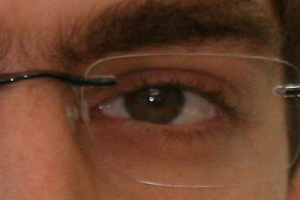

In [73]:
#Visualization of Iris
from PIL import Image
Image.open(train_path+'C100_S2_I3.tiff').resize((300,200))

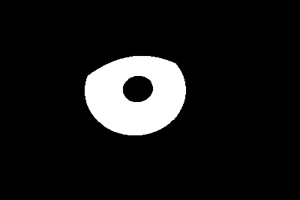

In [74]:
#Visualization of Mask
Image.open(mask_path+'OperatorA_C2_S1_I11.tiff').resize((300,200))

In [75]:
#Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential

In [76]:
print("train set:  ", len(os.listdir(train_path)))
print("train masks:", len(os.listdir(mask_path)))
#print("test set:   ", len(os.listdir("/kaggle/working/test")))

train set:   1160
train masks: 50


In [77]:
from glob import glob
train_filepaths = glob(os.path.join(train_path, "*.tiff"))
train_masks_filepaths = glob(os.path.join(mask_path, "*.tiff"))
#test_filepaths = glob(os.path.join(test_path, "*.jpg"))

# Get unique ids of images
def get_root_name(filepaths):
    file_names = [os.path.basename(filepath) for filepath in filepaths]
    root_name = [name.split("_")[0] for name in file_names]
    return root_name

all_train_ids = set(get_root_name(train_filepaths))
all_train_masks_ids = set(get_root_name(train_masks_filepaths))
#all_test_ids = set(get_root_name(test_filepaths))

In [78]:
print("training set:       ", len(all_train_ids), " different iris")
print("training masks set: ", len(all_train_masks_ids), "different mask")
#print("test set:           ", len(all_test_ids), "different cars")

training set:        53  different iris
training masks set:  1 different mask


In [79]:
all_train_ids

{'C10',
 'C100',
 'C101',
 'C102',
 'C103',
 'C104',
 'C105',
 'C106',
 'C107',
 'C108',
 'C109',
 'C11',
 'C110',
 'C111',
 'C112',
 'C113',
 'C114',
 'C115',
 'C116',
 'C117',
 'C118',
 'C119',
 'C12',
 'C120',
 'C121',
 'C122',
 'C123',
 'C124',
 'C125',
 'C126',
 'C127',
 'C128',
 'C129',
 'C13',
 'C130',
 'C131',
 'C132',
 'C133',
 'C134',
 'C135',
 'C136',
 'C137',
 'C138',
 'C139',
 'C140',
 'C141',
 'C142',
 'C143',
 'C144',
 'C145',
 'C146',
 'C147',
 'C148'}

In [80]:
all_train_masks_ids

{'OperatorA'}

## Training and Validation Split

In [90]:
def get_image_id(path):
    return os.path.splitext(os.path.basename(path))[0]

df = pd.DataFrame(dict(image_path=train_filepaths))
df['image_id'] = df['image_path'].map(lambda path: get_image_id(path))
df['mask_path'] = df['image_path'].map(
    lambda x: x.replace('train', 'train').replace('.tiff', '.tiff'))
df['car_id'] = df['image_id'].map(lambda img_id: img_id.split('_')[0])
df

,image_path,image_id,mask_path,car_id
0,/content/drive/My Drive/final_year_project/tra...,C100_S2_I3,/content/drive/My Drive/final_year_project/tra...,C100
1,/content/drive/My Drive/final_year_project/tra...,C100_S2_I4,/content/drive/My Drive/final_year_project/tra...,C100
2,/content/drive/My Drive/final_year_project/tra...,C125_S2_I10,/content/drive/My Drive/final_year_project/tra...,C125
3,/content/drive/My Drive/final_year_project/tra...,C126_S2_I10,/content/drive/My Drive/final_year_project/tra...,C126
4,/content/drive/My Drive/final_year_project/tra...,C100_S2_I8,/content/drive/My Drive/final_year_project/tra...,C100
...,...,...,...,...
1155,/content/drive/My Drive/final_year_project/tra...,C147_S2_I2,/content/drive/My Drive/final_year_project/tra...,C147
1156,/content/drive/My Drive/final_year_project/tra...,C126_S2_I9,/content/drive/My Drive/final_year_project/tra...,C126
1157,/content/drive/My Drive/final_year_project/tra...,C147_S2_I7,/content/drive/My Drive/final_year_project/tra...,C147
1158,/content/drive/My Drive/final_year_project/tra...,C125_S2_I9,/content/drive/My Drive/final_year_project/tra...,C125


In [82]:
from sklearn.model_selection import train_test_split

def split_data(ids, col="car_id"):
    train_ids, valid_ids = train_test_split(ids, random_state=42, test_size=.2)
    valid_ids, test_ids = train_test_split(valid_ids, random_state=42, test_size=.5)
    train_df = df[df[col].isin(train_ids)]
    valid_df = df[df[col].isin(valid_ids)]
    test_df = df[df[col].isin(test_ids)]
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(list(all_train_ids))
print("train_df: ", train_df.shape[0])
print("valid_df: ", valid_df.shape[0])
print("test_df:  ", test_df.shape[0])

train_df:  935
valid_df:  105
test_df:   120


In [83]:
train_df.head()

,image_path,image_id,mask_path,car_id
0,/content/drive/My Drive/final_year_project/tra...,C100_S2_I3,/content/drive/My Drive/final_year_project/tra...,C100
1,/content/drive/My Drive/final_year_project/tra...,C100_S2_I4,/content/drive/My Drive/final_year_project/tra...,C100
2,/content/drive/My Drive/final_year_project/tra...,C125_S2_I10,/content/drive/My Drive/final_year_project/tra...,C125
3,/content/drive/My Drive/final_year_project/tra...,C126_S2_I10,/content/drive/My Drive/final_year_project/tra...,C126
4,/content/drive/My Drive/final_year_project/tra...,C100_S2_I8,/content/drive/My Drive/final_year_project/tra...,C100


## Preprocessing the data
Here, we build an input pipline using tf.data. We first load the data from the dataframe above, then we preprocess the image and the mask, and finally, we perform a simple data augmentation.

In [84]:
from tensorflow.image import stateless_random_crop, stateless_random_brightness

IMG_SIZE = [512, 512]
rng = tf.random.Generator.from_seed(1)

def decode(path):
    img = tf.io.read_file(path) 
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

@tf.function
def preprocess(image_path, mask_path):
    image = decode(image_path)
    mask = decode(mask_path)
    mask = mask[:, :, :1] # take one channel
    return image, mask

@tf.function
def data_augmentation(image, mask):
    if rng.uniform(()) > 0.5: 
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    seed = rng.make_seeds(2)[0]
    image = stateless_random_brightness(image, max_delta=0.1, seed=seed)
    return image, mask

def make_dataset(df, shuffle=False, augment=False, batch_size=16, buffer_size=1000):
    ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
    ds = ds.map(preprocess, num_parallel_calls=5)
    if shuffle:
        ds = ds.shuffle(buffer_size)
    if augment:
        ds = ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

train_data = make_dataset(train_df, shuffle=True, augment=True)
valid_data = make_dataset(valid_df)
test_data = make_dataset(test_df)

## Define the Model

In [85]:
def upsample(filters, size, strides, dropout=None):
    """Upsample the input"""

    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                      padding="same",
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if dropout:
        result.add(tf.keras.layers.Dropout(dropout))
    result.add(tf.keras.layers.ReLU())   
    return result

To have a better performance, I used the layers of the VGG19 as the encoder for the U-Net model. The decoder will be a series of the upsample block above.

In [86]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(input_shape=IMG_SIZE + [3], include_top=False, weights="imagenet")

layers_names = [
    "block2_conv1",    # 256x256
    "block2_conv2",    # 256x256
    "block3_conv1",    # 128x128
    "block3_conv2",    # 128x128
    "block4_conv1",    # 64x64
    "block4_conv2",    # 64x64
    "block5_conv1",    # 32x32
]

layers = [base_model.get_layer(name).output for name in layers_names]
down_stack = Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

up_stack = [
    upsample(512, 3, 1),   # 32x32 -> 32x32
    upsample(512, 3, 2),   # 32x32 -> 64x64
    upsample(256, 3, 1),   # 64x64 -> 64x64 
    upsample(256, 3, 2),   # 64x64 -> 128x128
    upsample(128, 3, 1),   # 128x128 -> 128x128
    upsample(128, 3, 2),   # 128x128 -> 256x256
]

## Build the U-Net model

In [87]:
def unet_generator(output_channels=1):
    inputs = tf.keras.layers.Input(shape=IMG_SIZE + [3])
    x = inputs

    initializer = tf.random_normal_initializer(0., 0.02)
    output = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding="same", kernel_initializer=initializer
    )
    
    concat = tf.keras.layers.Concatenate()

    # Downsampling 
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connection
    for up, skip in zip (up_stack, skips):
        x = up(x)
        if up.layers[0].strides == (2, 2):
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

    x = output(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_generator()

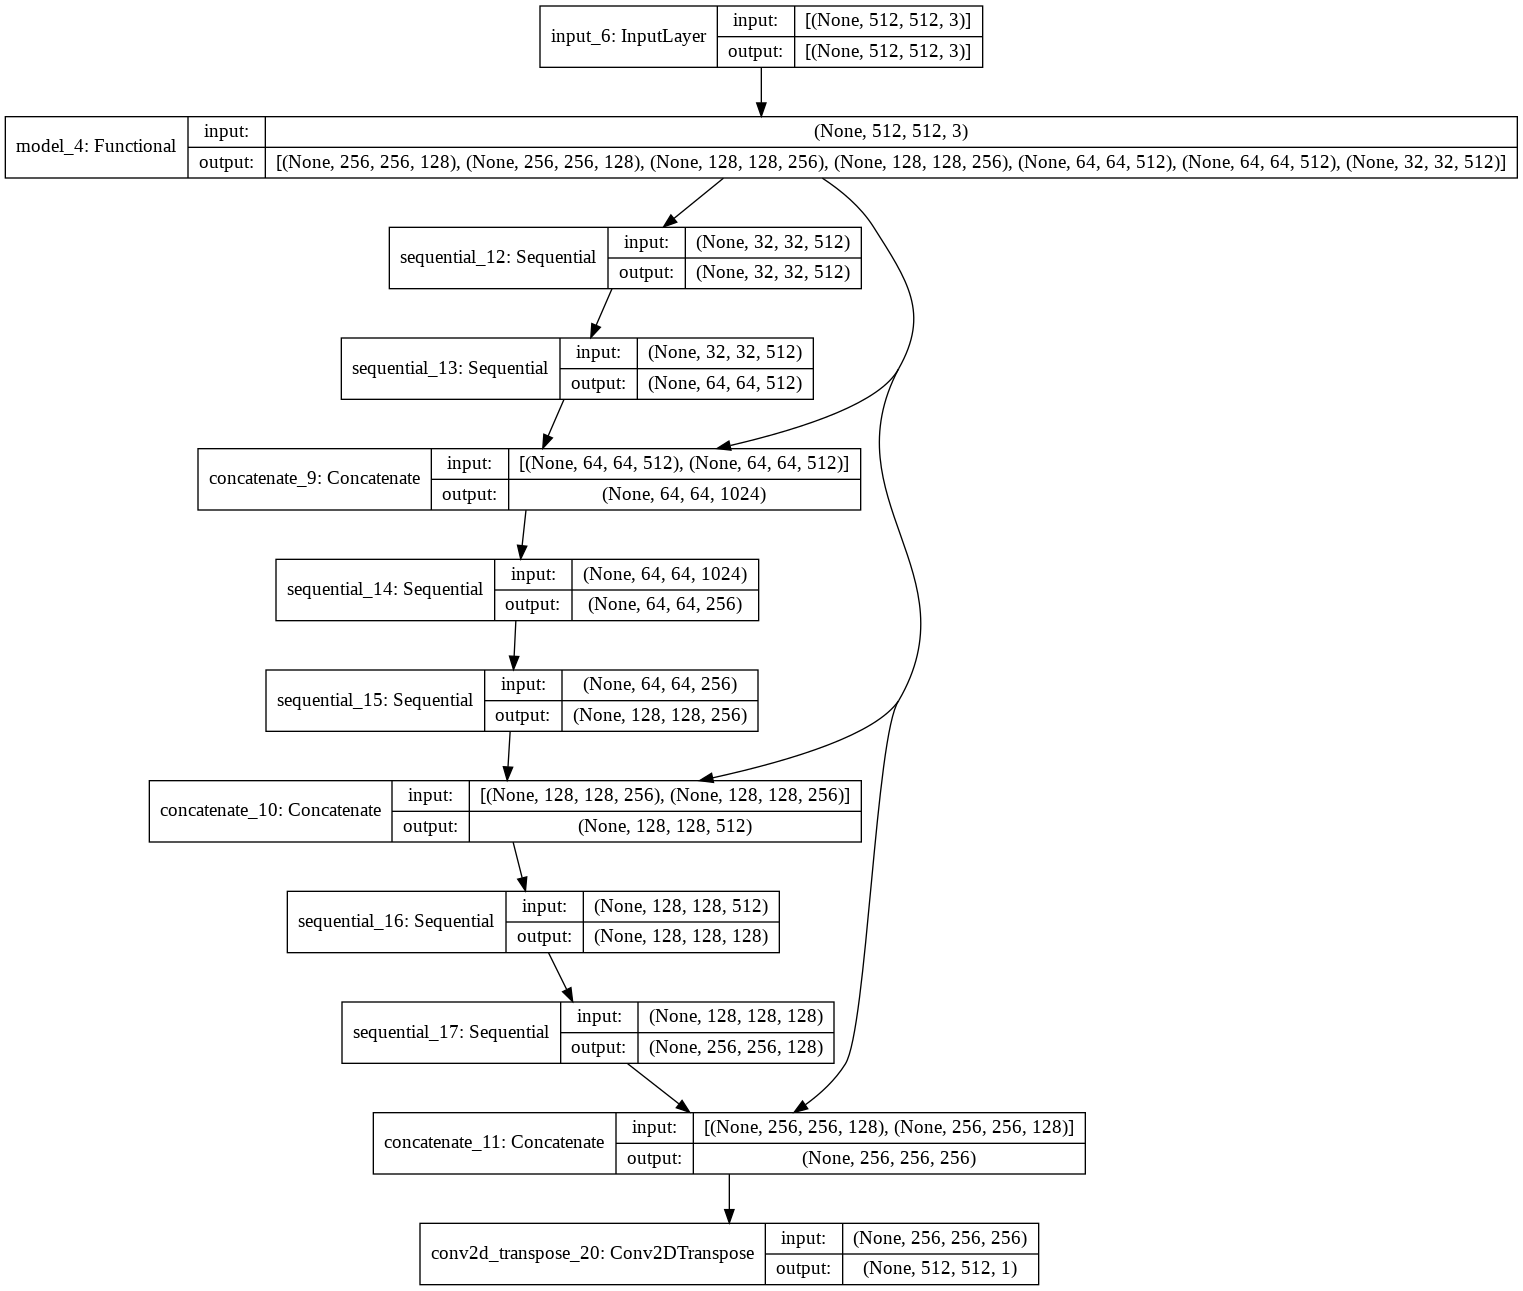

In [88]:
keras.utils.plot_model(model, show_shapes=True)

In [89]:
for images, masks in train_data.take(1):
  for img, mask in zip(images, masks):
    sample_image = img
    sample_mask = mask
    break

InvalidArgumentError: ignored

In [ ]:
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(IMG_SIZE[0],IMG_SIZE[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)